<h1><center>Regularization</center></h1>

<br>
<center><font size="3">This notebook is a part of teaching material for CS-EJ3311 - Deep Learning with Python</font></center>
<center><font size="3">24.10.-11.12.2022</font></center>
<center><font size="3">Aalto University & FiTech.io</font></center>

Deep learning methods use hypothesis spaces spanned by large parametrized signal flow charts, referred to as artificial neural networks (ANNs). Mathematically, an ANN is nothing but a parametrized non-linear map from input to output. The input of an ANN are the features of a data point, its output is typically the prediction for the label value. The relation (map) between input and output is non-linear and depends on tunable parameters (weights and biases). The parameters of an ANN are tuned or learnt by optimization methods that aim at minimizing the average loss on a training set. 

A key challenge in deep learning is that the average loss on a training set is not sufficient to guide the tuning of ANN parameters. Indeed, large ANNs have many different parameter configurations that result in a very small (essentially zero) training error. Looking only at the training error does not allow to decide which of these parameter configurations is the best (in terms of performance outside the training set). **Regularization** techniques use additional information, assumptions or constraints that allow to choose between different ANN parameter configurations that result in similar training errors. **Regularization** helps to avoid overfitting the training set and, in turn, to ensure the trained ANN does well on "new" data points which are not contained in the training set.


A large class of regularization methods rests on an stability or smoothness assumption. This assumption requires the trained ANN to deliver similar predictions for data points with similar feature values. As any regularization technique, also the smoothness assumption can be implemented via each of the three main components of DL. In particular, this notebook teaches you the following regularization strategies: 

* **data** augmentation: we can augment the training set by cloning data points using slightly perturbed feature values but leave label values untouched. 

* **model** pruning: we can try to remove non-smooth maps from the hypothesis space, e.g., by placing constraints on the parameter configurations. 

* **loss** modification: we can add a regularization term to the original average loss on the training error. Examples for such a regularization term are squared Euclidean norm ($L2$ norm) or the $L1$ norm of the ANN parameters. 

In [1]:
from utils import load_styles

# This MUST be the last line of this cell
load_styles()

## Learning goals


In this notebook, you will learn 

* how to implement regularization by data augmentation
* how one can use regularization to (smoothly) decrease the size of hypothesis space
* how to implement regularization by adding a penalty term to the loss function


## Additional  Reading

- Chapter 5.4 "Improving generalization" of "Deep Learning with Python" by F.Chollet. 
- Chapter 11 "Avoiding Overfitting Through Regularization" of "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" by Aurélien Géron. 
- Chapter 7 of A.Jung, ["Machine Learning: The Basics,"](https://github.com/alexjungaalto/MachineLearningTheBasics/blob/master/MLBasicsBook.pdf) Springer, Sinagpore 2022. 

<h1><center> Data augmentation  </center></h1>

Consider a basic deep learning setup, where we train ANN parameters by minimizing its average loss on a training set consisting of $m$ labeled data points. Let us assume that we can measure the size of the hypothesis space spanned by the ANN using some number $d_{\rm eff}$ that we might refer to as **effective dimension**. As a rule of thumb (cf. alex.jung@aalto.fi), the ANN training will be successful (not overfit) as soon as 


$$ m \geq 10 d_{\rm eff}. (Alex's RuleOfThumb) $$

One way to combat overfitting is to collect more (raw) data points to increase $m$. However, this is not always feasible, be it due to budget constraints (need to pay people to label the data) or time constraints. Data augmentation generates new data points synthetically, avoiding the need for collecting new raw data. The idea is to exploit known symmetries in the features and labels of data points. As a case in point, consider the problem of detecting the presence of an object in an image. Here, we can generated new labeled images by rotating, cropping or changing pixel values slightly, since these don't change the class. Loosely speaking, "a rotated cat image is still showing a cat". 

<div class="info">
    <div  class="info-title"><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Info</div><br>
    <div class="wrap-up-content">
        <b>The effective dimension</b> of an infinite hypothesis space is a measure of its size. Loosely speaking, the effective dimension is equal to the number of "independent" tunable parameters of the model. These parameters might be the coefficients used in a linear map or the weights and bias terms of an ANN.
    </div>
</div>

In [2]:
import pandas as pd
import numpy as np                    # library for numerical computations (vectors, matrices, tensors)
import matplotlib.pyplot as plt       # library providing tools for plotting data 
import tensorflow as tf               # open source library for deep learning
from tensorflow import keras          # library providing methods for defining and training ANN 
from tensorflow.keras import layers, regularizers 
from math import isclose

np.random.seed(1)
tf.random.set_seed(1)

Fontconfig error: Cannot load default config file: No such file: (null)


In [3]:
# set trainig = False when validating or submitting notebook
# and set training = True, when training network
training=False

In [4]:
# this is a hidden cell to set training=False


In this notebook we use the subset of [Fashion-MNIST ](https://www.tensorflow.org/datasets/catalog/fashion_mnist) dataset:

In [5]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# load dataset
from tensorflow.keras.datasets import fashion_mnist
(trainval_images, trainval_labels), (test_images, test_labels) = fashion_mnist.load_data()

# shape of train and test image
print(f'Number of training and validation examples {trainval_images.shape}')
print(f'Number of test examples {test_images.shape}')

4431872/4422102 [==============================] - 0s 0us/step
Number of training and validation examples (60000, 28, 28)
Number of test examples (10000, 28, 28)


In [6]:
# select subset of trainval_images and trainval_labels
X_trainval = trainval_images[:16000]
y_trainval = trainval_labels[:16000]

# select whole test set
X_test = test_images
y_test = test_labels

In [7]:
# flatten 2D image to 1D feature vector 
X_trainval = X_trainval.reshape(-1, 28 * 28)
X_test = test_images.reshape(-1, 28 * 28)

In [8]:
# Normalize data to have feature values between 0 and 1
X_trainval = X_trainval/ 255.0
X_test = X_test/ 255.0

<a id='St1'></a>
<div class=" alert alert-warning">
    <h3><b>Student task.</b> Build "base" ANN without regularization.</h3>  
    
    
Your task is to build (we will do compiling and training model later) a following ANN for **Fashion-MNIST classification dataset**:
    
- Dense layer with 128 units and ReLU activation, input_shape=(784,)
- Dense layer with 64 units and ReLU activation
- Dense layer with 32 units and ReLU activation
- Dense output layer with 10 units and softmax activation function   
</div>

Note: Ignore warning "This TensorFlow binary is optimized with oneAPI ..."

2022-11-22 22:18:02.544774: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Fontconfig error: Cannot load default config file: No such file: (null)



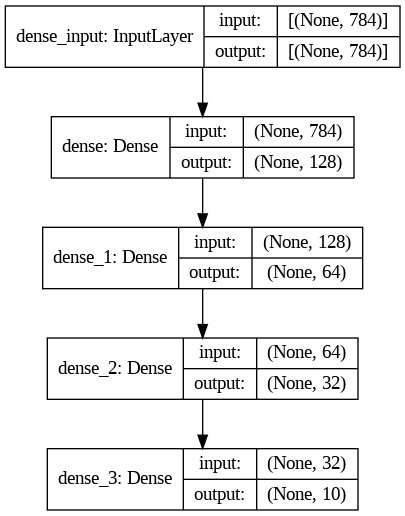

In [9]:
# YOUR CODE HERE
# raise NotImplementedError()
model_base = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, input_shape=(784,), activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax"),
])
tf.keras.utils.plot_model(model_base, show_shapes=True, show_layer_names=True)

In [10]:
# Perform some sanity checks on the solution
assert len(model_base.layers) == 4, "There should be 4 layers!"
assert model_base.layers[0].input_shape[1:] == (784,), "Input shape is wrong"
assert model_base.layers[0].output_shape[1:] == (128,), "Output shape is wrong"

print("Sanity checks passed!")

Sanity checks passed!


In [11]:
# this cell is for tests


<a id='St1'></a>
<div class=" alert alert-info">
    <h3><b>Demo.</b> Data augmentation: Image rotation and flip.</h3>  

Here we implement data augmentation technique for images by rotating and flipping original images.

We will use Keras [Image augmentation layers](https://keras.io/api/layers/preprocessing_layers/image_augmentation/) `RandomFlip` and `RandomRotation`.
    
`RandomFlip` layer flips an image horizontally, vertically or both, according to its argument `mode` (takes strings "horizontal", "vertical", or "horizontal_and_vertical" as input).
    
`RandomRotation` layer rotates image by a random angle defined by argument `factor`. For example, `factor=0.2` results in an output rotating by a random amount in the range `[-20% * 2pi, 20% * 2pi]`.
</div>

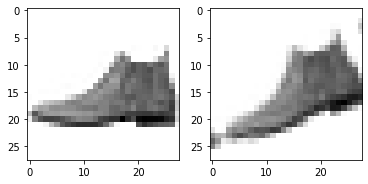

In [12]:
# create data augmentation layer
data_aug_layer = tf.keras.Sequential([
            # input is a 3D array - image (hight, width, channels)
            layers.RandomFlip("horizontal", input_shape=(28, 28, 1), seed=42),
            layers.RandomRotation(0.1, seed=42),
            ])

# select first data point of the test set 
# reshape to (n.o. samples, hight, width, channels)
X_no_aug = X_test[0].reshape(1, 28, 28, 1)
# apply data augmentation to selected image
X_aug    = data_aug_layer(X_no_aug)

fig, ax = plt.subplots(1,2)
ax[0].imshow(X_no_aug[0], cmap='binary') 
ax[1].imshow(X_aug[0], cmap='binary') 
plt.show()

In [13]:
# add data augmentation layer to the model
model_data_aug = keras.Sequential([
            data_aug_layer,
            # flatten input as the output of data_aug_layer is of shape (n.o. samples, hight, width, channels)
            # and for Dense layers we need shape (n.o. samples, features)
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(10, activation='softmax')
            ])

<a id='St1'></a>
<div class=" alert alert-info">
    <h3><b>Demo.</b> Data augmentation: Adding Gaussian noise to the image.</h3>  

Data augmentation can be applied to the data types other than images by slighly disturbing original feature values, i.e. by adding some noise to the original data.
    
Below, we add Gaussian noise by using [GaussianNoise](https://keras.io/api/layers/regularization_layers/gaussian_noise/) layer. The argument `stddev` is a float value defining standard deviation of the noise distribution.
    
GaussianNoise layer is only active at a training time, thus we need to set argument `training=True` in order to add noise to the image and plot the result.
</div>

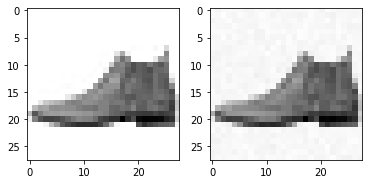

In [14]:
# create data augmentation layer
noise_layer = tf.keras.Sequential([
            layers.GaussianNoise(stddev=0.01, input_shape=(784,))
            ])

# select first data point of the test set and reshape (for plotting)
X_no_noise = X_test[0].reshape(28, 28, 1)
# apply data augmentation to the first data point of the test set
X_noise = noise_layer(X_test[0], training=True)
# reshape (for plotting)
X_noise = X_noise.numpy().reshape(28, 28, 1)

fig, ax = plt.subplots(1,2)
ax[0].imshow(X_no_noise, cmap='binary') 
ax[1].imshow(X_noise, cmap='binary') 

plt.show()

In [15]:
# add data augmentation layer to the model
model_noise = keras.Sequential([
            # add GaussianNoise layer
            noise_layer,
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(10, activation='softmax')
            ])

## Dropout

Data augmentation methods perturb features or labels of existing data points to obtain new (synthetic) data points. These perturbations include geometric transformations for image data or adding small amounts of noise to features of the data points. Dropout is another example for a perturbation technique that is well-suited for the training of ANNs. Instead of manipulating the features of a data point, dropout perturbs the activations of an ANN (i.e. output of the hidden neurons). In particular, as its name suggests, dropout randomly chooses a subset of neurons whose output is set to zero. As explained in the paper by X. Bouthillier, K. Konda, P. Vincent, R. Memisevic  "Dropout as data augmentation":

<blockquote>
Dropout is interpreted as bagging a large number of models sharing parameters. We show that using dropout in a network can also be interpreted as a kind of data augmentation in the input space without domain knowledge. We present an approach to projecting the dropout noise within a network back into the input space, thereby generating augmented versions of the training data, and we show that training a deterministic network on the augmented samples yields similar results. Finally, we propose a new dropout noise scheme based on our observations and show that it improves dropout results without adding significant computational cost.
</blockquote>

<img src="../../../coursedata/Regularization/dropout.png" />

More about dropout in [Andrew Ng video](https://www.youtube.com/watch?v=D8PJAL-MZv8).

<a id='St1'></a>
<div class=" alert alert-info">
    <h3><b>Demo.</b>  Data augmentation: ANN with Dropout Layers.</h3>  

In Keras, dropout technique is implemented with [`Dropout` layer](https://keras.io/api/layers/regularization_layers/dropout/). The `Dropout` layer randomly sets its input units to 0 with a frequency defined by arg `rate` at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - `rate`) such that the sum over all inputs is unchanged.

Note that the Dropout layer only applies during training (when using `model.fit()`), but not during inference (when using `model.evaluate()`).
</div>

In [16]:
# rate arg: Float between 0 and 1. Fraction of the input units to drop
drate = 0.1

model_dropout = keras.Sequential([
    layers.Dense(128, activation='relu',input_shape=(784,)),
    layers.Dropout(drate),
    layers.Dense(64, activation='relu'),
    layers.Dropout(drate),
    layers.Dense(32, activation='relu'),
    layers.Dropout(drate),
    layers.Dense(10, activation='softmax')
])

<a id='St1'></a>
<div class=" alert alert-warning">
    <h3><b>Student task.</b> Compile and Train ANNs.</h3>  

Use models from a list `models` and Fashion-MNIST dataset to classify 28x28 pixels grayscale images into 10 different classes, corresponding to specific fashion item:

- For each model in a list `models` (models' architectures were defined above), compile and train the model. 
- Use optimizer - RMSprop, loss - `sparse_categorical_crossentropy` and  metrics -  `sparse_categorical_accuracy`. \
Training parameters: `history = model.fit(X_trainval, y_trainval, validation_split=0.2, batch_size=32, epochs=20)`.
 
- Store history object for each model in a list `history_log`. 
- Save trained model as `model_name_here.h5`. Corresponding model names are retrieved from `model_names` list.
    
Note, that for the model `model_data_aug` the shape of the input should be $(m,28,28,1)$, i.e. reshape input features to (-1,28,28,1).
</div>

<div class=" alert alert-danger">
    <h3 align='center'>Test accuracy should be $\geq$ 0.80 for all models.</h3>
</div>

In [17]:
# list of ANNs without and with data augmentation
models = [model_base, model_data_aug, model_noise, model_dropout]

# use this list when saving model
model_names = ['model_base', 'model_data_aug', 'model_noise', 'model_dropout']

# list to store training history
history_log = []

if training:
    # YOUR CODE HERE
    # raise NotImplementedError()
    # loop through `model_names`  and `models` lists to get model name and model itself
    for i in range(0, 4):
        # For each model in a list models, compile and train the model
        models[i].compile(optimizer="RMSprop", loss='sparse_categorical_crossentropy', metrics="sparse_categorical_accuracy")
        
        # for the model model_data_aug the shape of the input should be (𝑚,28,28,1)
        if model_names[i] == "model_data_aug": 
            X_trainval_copy = X_trainval
            history = models[i].fit(X_trainval_copy.reshape(-1,28,28,1), y_trainval, validation_split=0.2, batch_size=32, epochs=20, verbose=1)
        else:
            history = models[i].fit(X_trainval, y_trainval, validation_split=0.2, batch_size=32, epochs=20, verbose=1)
        print(f"Finish training {model_names[i]}")
        # Store history object for each model in a list history_log
        history_log.append(history)
        
        # Save trained model as model_name_here.h5
        models[i].save(f"{model_names[i]}.h5")
        
else:
    model_base     = tf.keras.models.load_model("model_base.h5")
    model_data_aug = tf.keras.models.load_model("model_data_aug.h5")
    model_noise    = tf.keras.models.load_model("model_noise.h5")
    model_dropout  = tf.keras.models.load_model("model_dropout.h5")

In [18]:
# evaluate trained models

_, test_accuracy = model_base.evaluate(X_test, y_test, verbose=0)
print(f'Base model - Accuracy on test dataset: {test_accuracy: .4f}')

_, test_accuracy = model_data_aug.evaluate(X_test.reshape(-1,28,28,1), y_test, verbose=0)
print(f'Flip & Rotation - Accuracy on test dataset: {test_accuracy: .4f}')

_, test_accuracy = model_noise.evaluate(X_test, y_test, verbose=0)
print(f'Noise - Accuracy on test dataset: {test_accuracy: .4f}')

_, test_accuracy = model_dropout.evaluate(X_test, y_test, verbose=0)
print(f'Dropout - Accuracy on test dataset: {test_accuracy: .4f}')

2022-11-22 22:18:04.843320: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Base model - Accuracy on test dataset:  0.8601
Flip & Rotation - Accuracy on test dataset:  0.8117
Noise - Accuracy on test dataset:  0.8603
Dropout - Accuracy on test dataset:  0.8590


In [19]:
# Sanity checks

# Load saved models
model_base     = tf.keras.models.load_model("model_base.h5")
model_data_aug = tf.keras.models.load_model("model_data_aug.h5")
model_noise    = tf.keras.models.load_model("model_noise.h5")
model_dropout  = tf.keras.models.load_model("model_dropout.h5")

# Check n.o. layers
assert len(model_base.layers) == 4, "`model_base` should have 4 layers!"
assert len(model_data_aug.layers) == 6, "`model_data_aug` should have 6 layers!"
assert len(model_noise.layers) == 5, "`model_noise` should have 5 layers!"
assert len(model_dropout.layers) == 7, "`model_dropout` should have 7 layers!"

In [20]:
# cell for hidden test


In [21]:
# cell for hidden test


In [22]:
# cell for hidden test


In [23]:
# cell for hidden test


In [24]:
if training:
    fig, axes = plt.subplots(1,4, sharey=True, figsize=(14,4))
    title = ['base', 'rotation & flip', 'noise', 'dropout']

    ax = axes.flat
    for i, history in enumerate(history_log):
        ax[i].plot(history.history['sparse_categorical_accuracy'])
        ax[i].plot(history.history['val_sparse_categorical_accuracy'])
        ax[i].spines["top"].set_visible(False)
        ax[i].spines["right"].set_visible(False)
        ax[i].set_title(title[i], fontsize=18)
        ax[i].grid()

    ax[0].set_xlabel('epoch', fontsize=14)
    ax[0].set_ylabel('Accuracy', fontsize=14)

    fig.tight_layout()
    plt.legend(['train', 'val'])
    plt.show()

We can see that data augmentation with image rotation and flipping worsened the model trained compared to base model. Adding noise to the data lead to similar results as the base model and applying dropout prevented overfitting, but didn't improve test accuracy significantly. In order to improve validation and test accuracy we have to adjust regularization hyperparameters, i.e. do hyperparameter tuning. For example, increasing number of epochs for a model with dropout layers or adjusting the value of `stddev` argument of `GaussianNoise` layer may lead to better results.

<h1><center>Model pruning</center></h1>

According to the "RuleOfThumb" above, instead of increasing the size of the training set, we can also try to reduce the effective dimension of the ANN hypothesis space. In other words, we can avoid overfittng by using a smaller hypothesis space over which we search during training. Maybe the most obvious way to reduce the hypothesis space is to make the ANN smaller by removing hidden layers. Another option is to fix or "freeze" the parameters (weights, bias terms) of some of the layers. This approach is known as **transfer learning**. We next study **early stopping** as a more subtle means to prune the hypothesis space (model) of an ANN. 

## Early stopping

Nominally, the hypothesis space (or model) associated with a given ANN is constituted by all maps $h: \mathbf{x} \mapsto h(\mathbf{x})$ that can be obtained from different choices for its parameters $\mathbf{w}$. These parameters consist of the bias and (input) weights for each neurons in the ANN. Early stopping implements this pruning by limiting the number of gradient descent steps executed during the training. The training of an ANN typically starts from initial choice or guess $\mathbf{w}^{(0)}$ which is then iteratively improved using some gradient descent method, $\mathbf{w}^{(k+1)} = {\rm SomeUpdateRule} \big\{ \mathbf{w}^{(k)} \big\}$. Early stopping constraints the hypothesis space by stopping this update after a relatively small number of iterations.

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-28_at_12.59.56_PM_1D7lrVF.png" width="600"/>
</br>

More about data augmentation and early stopping in [Andrew Ng video](https://www.youtube.com/watch?v=BOCLq2gpcGU).

<h1><center>Loss modification</center></h1>


## Parameter norm penalties

One type of regularization techniques is parameter norm penalties. For example, $L1$ and $L2$ norm regularization, in which model is trained by minimizing a cost function that penalizes the large norm values of a model's parameters. Both of these alternatives are based on the premise that the complexity of a predictor increases with the magnitude of its parameters.


The cost function that is minimized when training a regularized model $h$ is composed of the training loss and an additional **penalty term**:


\begin{equation}
 \mathcal{E}(h) = \underbrace{\underbrace{(1/m_{t}) \sum_{\big(\mathbf{x}^{(i)},y^{(i)}\big) \in \mathbb{X}^{(t)}} \mathcal L \big( (x^{(i)}, y^{(i)}), h \big)}_{\mbox{ training loss}} + \underbrace{\alpha \mathcal{R}(h)}_{\mbox{anticipated increase of error (loss) on new data}}}_{\mbox{ estimate (approximation) of test error }}
\end{equation}

The central idea of regularization is that the penalized cost function is minimized by a less complex predictor than the average loss. Thus, a model trained using the penalized cost function should, in general, have better generalization capabilities provided that the penalty term is well chosen. 

The penalty term itself is composed of two factors - a **regularization term** $\mathcal{R}(h)$ and a scaling factor $\alpha$. The former quantifies a function's complexity, and the latter scales the penalty by a specified factor. Effectively, $\alpha$ **offers a trade-off between the prediction error (training loss) incurred on the training data and the complexity of a predictor**. Large $\alpha$ favor less complex predictor functions, while small $\alpha$ put more emphasis on obtaining a small training loss.


In order to implement regularization in practice, we need to choose a regularization term $\mathcal{R}$ that quantifies the complexity of predictor functions in an appropriate way. Two widely used choices are the $L1$ norm 

\begin{equation}
\|\mathbf{w} \|_1 = \sum_{i=1}^n |w_i|= |w_1| + |w_2| + \ldots + |w_n|
\end{equation}

and the squared $L2$ norm

\begin{equation}
\|\mathbf{w} \|_2^2 = \sum_{i=1}^n w_i^2 = w_1^2 + w_2^2 + \ldots + w_n^2.
\end{equation}


$L2$ norm harshly penalizes predictors with large weights, while $L1$ norm does not square the weights in the penalty, and thus, both large and small weights are penalized proportionately.


More about norm penalties in [Andrew Ng video](https://www.youtube.com/watch?v=6g0t3Phly2M).

<a id='St1'></a>
<div class=" alert alert-info">
    <h3><b>Demo.</b> $L1$ regularization.</h3>  

In Keras we can add norm penalties to ANN weights and biases by passing regularizer to arguments `kernel_regularizer` and `bias_regularizer` of a keras layer. 
    
Below we apply $L1$ regularization to weights of feed-forward ANN with Keras [layer weight regularizers](https://keras.io/api/layers/regularizers/). We use `regularizers.L1()` with scaling factor $\alpha=1e-4$ as regularizer for model's weights.
    
</div>

In [25]:
# scaling factor alpha
alpha_l1 = 1e-4

model_l1 = keras.Sequential([
    layers.Dense(128, activation='relu',input_shape=(784,),
                kernel_regularizer = regularizers.L1(alpha_l1)),
    layers.Dense(64, activation='relu', 
                kernel_regularizer = regularizers.L1(alpha_l1)),
    layers.Dense(32, activation='relu',
                kernel_regularizer = regularizers.L1(alpha_l1)),
    layers.Dense(10, activation='softmax')
])

<a id='St1'></a>
<div class=" alert alert-warning">
    <h3><b>Student task.</b> $L2$ regularization.</h3>  

Modify code snippet above and apply $L2$ regularization with scaling factor alpha=1e-4 instead of $L1$ regularization. See Keras [documentation](https://keras.io/api/layers/regularizers/#l2-class).
    
</div>

In [26]:
# scaling factor alpha
alpha_l2 = 1e-4

# YOUR CODE HERE
# raise NotImplementedError()

model_l2 = keras.Sequential([
    layers.Dense(128, activation='relu',input_shape=(784,),
                kernel_regularizer = regularizers.L2(alpha_l2)),
    layers.Dense(64, activation='relu', 
                kernel_regularizer = regularizers.L2(alpha_l2)),
    layers.Dense(32, activation='relu',
                kernel_regularizer = regularizers.L2(alpha_l2)),
    layers.Dense(10, activation='softmax')
])

In [27]:
# Perform some sanity checks on the solution
assert len(model_l2.layers) == 4, "There should be 4 layers!"
assert model_l2.layers[0].get_config()['kernel_regularizer']['class_name'] == 'L2', "L2 regularization is missing!"

print("Sanity checks passed!")

Sanity checks passed!


In [28]:
# cell for hidden test


## Hyperparameter tuning (choosing $\alpha$)

The $\alpha$ factor in the regularized cost function is a **hyperparameter** of the regularized model. In contrast to **model parameters**, hyperparameters are not optimized by training the model but must be defined in advance. The hyperparameters' values are typically chosen by selecting the value from a set of candidates that results in the lowest validation error for the trained model. This process is called **hyperparameter tuning** and can be seen as a case of model selection, in which the models differ by the values of the hyperparameters.

The hyperparameter tuning process for $\alpha$ proceeds roughly as follows:
1. we specify a list of candidate values for $\alpha$, 
2. for each choice of $\alpha$, we learn a predictor that minimizes the regularized cost function
3. for each choice of $\alpha$, we validate the trained predictor $h^{(\alpha)}_{\rm opt}$ by computing the validation error

\begin{equation}
E_{\rm val}^{(\alpha)} = (1/m_{\rm v}) \sum_{\big(\mathbf{x}^{(i)},y^{(i)}\big) \in \mathbb{X}^{(v)}} \mathcal L \big( (x^{(i)} y^{(i)}), h)\big).
\end{equation}

4. We select the value of $\alpha$ with smallest validation error to be used in our final model 
5. We evaluate the final model on a test set

<a id='St1'></a>
<div class=" alert alert-warning">
    <h3><b>Student task.</b> Hyperparameter tuning.</h3>  

In this exercise we will use the following ANN for Fashion-MNIST classification dataset:
    
- Dense layer with 128 units, ReLU activation and $L2$ regularization for model weights
- Dense layer with 64 units, ReLU activation and $L2$ regularization for model weights
- Dense layer with 32 units, ReLU activation and $L2$ regularization for model weights
- Dense output layer with 10 units and softmax activation function
    
Use optimizer - RMSprop, loss - `sparse_categorical_crossentropy` and metrics -  `sparse_categorical_accuracy`. 
Training parameters:
`history = model.fit(X_trainval, y_trainval, validation_split=0.2, batch_size=32, epochs=20)`

Your task is to implement a function `L2_hyperparam()`. The input parameter of this function `l2` is a list of regularization hyperparameter values $\alpha$. This function should, for each entry of that list:
    
- create a new ANN Sequential model (see instructions above). In this step, you need to pass the $\alpha$ value to the layer's $L2$ regularizer.
- compile the model
- train the model. Store history object for each model in a list `history_log`.
- compute the accuracy obtained on the test set and add this value to the list `test_acc`
    
After completing the above steps for each value in the list `l2`, the function should return lists `history_log` and  `test_acc`.
</div>

In [29]:
# list of L2 regularization scaling factor values
l2 = [1e-1, 1e-3, 0]

def L2_hyperparam(l2):
    # for reproducibility
    np.random.seed(1)
    tf.random.set_seed(1)

    history_log = [] # list to store training history
    test_acc = [] # list to store test accuracies
    
    # YOUR CODE HERE
    # raise NotImplementedError()
    # iterate list `l2`
    for alpha_l2 in l2:
        model = keras.Sequential([
            layers.Dense(128, activation='relu',input_shape=(784,),
                        kernel_regularizer = regularizers.L2(alpha_l2)),
            layers.Dense(64, activation='relu', 
                        kernel_regularizer = regularizers.L2(alpha_l2)),
            layers.Dense(32, activation='relu',
                        kernel_regularizer = regularizers.L2(alpha_l2)),
            layers.Dense(10, activation='softmax')
        ])
        model.compile(optimizer="RMSprop", loss='sparse_categorical_crossentropy', metrics="sparse_categorical_accuracy")
        
        history = model.fit(X_trainval, y_trainval, validation_split=0.2, batch_size=32, epochs=20)
        
        _, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        
        history_log.append(history)
        test_acc.append(test_accuracy)
    
    return history_log, test_acc

In [30]:
%%time 

# call  L2_hyperparam() function
history_log, test_acc = L2_hyperparam(l2)
print(test_acc)

Epoch 1/20
400/400 [==============================] - 3s 5ms/step - loss: 4.7896 - sparse_categorical_accuracy: 0.5508 - val_loss: 1.8568 - val_sparse_categorical_accuracy: 0.6569
Epoch 2/20
400/400 [==============================] - 1s 3ms/step - loss: 1.7527 - sparse_categorical_accuracy: 0.6135 - val_loss: 1.7045 - val_sparse_categorical_accuracy: 0.6109
Epoch 3/20
400/400 [==============================] - 2s 4ms/step - loss: 1.5896 - sparse_categorical_accuracy: 0.6572 - val_loss: 1.5572 - val_sparse_categorical_accuracy: 0.6600
Epoch 4/20
400/400 [==============================] - 2s 4ms/step - loss: 1.4873 - sparse_categorical_accuracy: 0.6827 - val_loss: 1.4319 - val_sparse_categorical_accuracy: 0.7041
Epoch 5/20
400/400 [==============================] - 2s 4ms/step - loss: 1.4231 - sparse_categorical_accuracy: 0.6954 - val_loss: 1.3799 - val_sparse_categorical_accuracy: 0.7147
Epoch 6/20
400/400 [==============================] - 2s 4ms/step - loss: 1.3722 - sparse_categorica

400/400 [==============================] - 2s 4ms/step - loss: 0.3402 - sparse_categorical_accuracy: 0.8732 - val_loss: 0.3889 - val_sparse_categorical_accuracy: 0.8656
Epoch 7/20
400/400 [==============================] - 1s 4ms/step - loss: 0.3205 - sparse_categorical_accuracy: 0.8827 - val_loss: 0.4050 - val_sparse_categorical_accuracy: 0.8581
Epoch 8/20
400/400 [==============================] - 2s 5ms/step - loss: 0.3076 - sparse_categorical_accuracy: 0.8875 - val_loss: 0.3750 - val_sparse_categorical_accuracy: 0.8706
Epoch 9/20
400/400 [==============================] - 2s 5ms/step - loss: 0.2969 - sparse_categorical_accuracy: 0.8883 - val_loss: 0.4493 - val_sparse_categorical_accuracy: 0.8541
Epoch 10/20
400/400 [==============================] - 2s 4ms/step - loss: 0.2840 - sparse_categorical_accuracy: 0.8916 - val_loss: 0.4115 - val_sparse_categorical_accuracy: 0.8566
Epoch 11/20
400/400 [==============================] - 2s 4ms/step - loss: 0.2718 - sparse_categorical_accurac

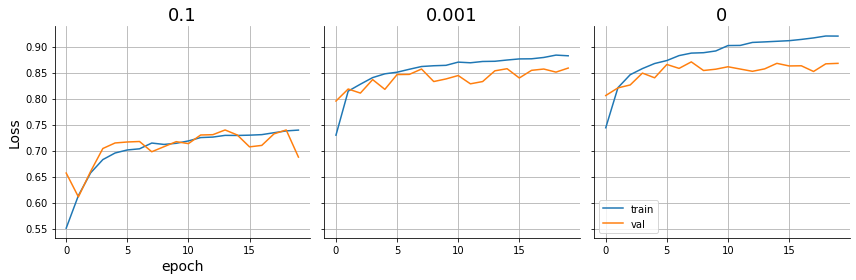

In [31]:
fig, axes = plt.subplots(1,3, sharey=True, figsize=(12,4))
title = [str(alpha_l2) for alpha_l2 in l2]

ax = axes.flat
for i in range(len(history_log)):
    ax[i].plot(history_log[i].history['sparse_categorical_accuracy'])
    ax[i].plot(history_log[i].history['val_sparse_categorical_accuracy'])
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].set_title(title[i], fontsize=18)
    ax[i].grid()

ax[0].set_xlabel('epoch', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)

fig.tight_layout()
plt.legend(['train', 'val'])
plt.show()

In [32]:
# Sanity check

assert len(test_acc)==3, 'Length of list `test_acc` should be equal to 3!'
# check accuracy values
assert test_acc[0]>=0.65 or isclose(test_accuracy, 0.65, abs_tol=2.5e-2), "Accuracy is too low!"
assert test_acc[1]>=0.83 or isclose(test_accuracy, 0.83, abs_tol=2.5e-2), "Accuracy is too low!"
assert test_acc[2]>=0.83 or isclose(test_accuracy, 0.83, abs_tol=2.5e-2), "Accuracy is too low!"
print('Sanity check tests passed!')

Sanity check tests passed!


In [33]:
# This cell is for tests


<a id='St1'></a>
<div class=" alert alert-warning">
    <h3><b>Student task.</b> Build ANN with Dropout Layers + L2 regularization.</h3>  

Although in our case the benefits of using regularization methods may not be evident, for large deep learning models it is quite common to use several regularization methods together.

In this task we will combine two regularization methods - $L2$ regularization of model's weights and dropout. Build the following ANN: 
    
- Dense layer with 128 units, ReLU activation and $L2$ regularization for model weights
- Dropout layer
- Dense layer with 64 units, ReLU activation and $L2$ regularization for model weights
- Dropout layer
- Dense layer with 32 units, ReLU activation and $L2$ regularization for model weights
- Dropout layer
- Dense layer with 10 units and softmax activation function
    
Use optimizer - RMSprop, loss - `sparse_categorical_crossentropy` and metrics -  `sparse_categorical_accuracy`. 
Training parameters:
`history = model.fit(X_trainval, y_trainval, validation_split=0.2, batch_size=32, epochs=20)`
    
- Save model as ` model_dropout_l2.h5`
   
</div>

<div class=" alert alert-danger">
    <h3 align='center'>Test accuracy should be $\geq$ 0.83 formodel_dropout_l2.</h3>
</div>

In [34]:
# dropout rate
drate = 0.1
# alpha value for L2 regularization
alpha_l2 = 1e-4

if training==True:
    # YOUR CODE HERE
    # raise NotImplementedError()

    model_dropout_l2 = keras.Sequential([
        layers.Dense(128, activation='relu',input_shape=(784,), kernel_regularizer = regularizers.L2(alpha_l2)),
        layers.Dropout(drate),
        layers.Dense(64, activation='relu', kernel_regularizer = regularizers.L2(alpha_l2)),
        layers.Dropout(drate),
        layers.Dense(32, activation='relu', kernel_regularizer = regularizers.L2(alpha_l2)),
        layers.Dropout(drate),
        layers.Dense(10, activation='softmax')
    ])

    model_dropout_l2.compile(optimizer="RMSprop", loss='sparse_categorical_crossentropy', metrics="sparse_categorical_accuracy")
        
    history = model_dropout_l2.fit(X_trainval, y_trainval, validation_split=0.2, batch_size=32, epochs=20)
    
    model_dropout_l2.save("model_dropout_l2.h5")
else:
    model_dropout_l2 = tf.keras.models.load_model("model_dropout_l2.h5")

In [35]:
_, test_accuracy = model_dropout_l2.evaluate(X_test, y_test, verbose=0)
print(f'Dropout - Accuracy on test dataset: {test_accuracy: .4f}')

Dropout - Accuracy on test dataset:  0.8357


In [36]:
# Sanity check

assert len(model_dropout_l2.layers) == 7, "There should be 7 layers!"
model_dropout_l2.layers[0].kernel_regularizer.l2 == regularizers.L2(alpha_l2).l2

True

In [37]:
# cell for hidden test


In [38]:
# Sanity checks
# check that all models from student tasks are saved

import os.path

# check that models  are saved
assert os.path.isfile('model_base.h5')==True, "Model `model_base` is not saved!"
assert os.path.isfile('model_data_aug.h5')==True, "Model `model_data_aug` is not saved!"
assert os.path.isfile('model_noise.h5')==True, "Model `model_noise` is not saved!"
assert os.path.isfile('model_dropout.h5')==True, "Model `model_dropout` is not saved!"
assert os.path.isfile('model_dropout_l2.h5')==True, "Model `model_dropout_l2` is not saved!"